In [1]:
import glob
import sys 

import numpy as np
import pandas as pd
import torch

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


from IPython.display import display

sys.path.append("../src")
from evaluate import evalSingleEdits
import utils
from utils import retrieveDataloader

In [47]:
class ModelComps:
    def __init__(self, model_name, base_name, archive=False):
        
        self.archive = archive
        self.model_name = model_name
        self.base_name = base_name
        self.ots_name = "OTS"
        self.models = {}
        self.modelStats = self.getModelParams()
        
        self.stats = {}
    
    
    def getModelParams(self):
        model_id = ".".join(self.model_name.split(".")[1:])
        return pd.Series(torch.load(f"../models/hypers.{model_id}")).to_frame().T
        

    def readData(self, model_name, kind='model'):
        if self.archive:
            eval_glob = glob.glob(f"./archive/*{model_name}")
        else:
            eval_glob = glob.glob(f"./*{model_name}")
        for evaluation in eval_glob:
            df = pd.read_csv(evaluation)
            eval_id = f"{kind}_{evaluation.split('.')[4].split('_')[0]}"
            self.models[eval_id] = df
    
    def runStats(self):
        if not self.models:
            self.readData(self.base_name, kind='base')
            self.readData(self.model_name)
            self.readData(self.ots_name, kind='ots')
            
        for name, model in self.models.items():  
            mean_new_ppl = model.new_ppl.mean() 
            mean_orig_ppl = model.orig_ppl.mean() 
            pct_ppl_dd = model.apply(lambda x: 100*(x.new_ppl - x.orig_ppl)/x.orig_ppl, axis=1).mean()
            gross_ppl_dd = model.apply(lambda x: x.new_ppl - x.orig_ppl, axis=1).mean()
            new_logits_higher = model.success.mean()
            new_logits_higher05 = model.apply(lambda x: x.new_logits > 0.95*x.orig_logits,axis=1).mean()
            new_logits_higher10 = model.apply(lambda x: x.new_logits > 0.90*x.orig_logits,axis=1).mean()

            success_by_probs = model.apply(lambda x: x.new_prob > x.old_prob, axis=1).mean()
            n_edit_steps = model.n_edit_steps.max()

            
            self.stats[name] = {
                "edit_steps":n_edit_steps,
                "mean_new_ppl":mean_new_ppl,
                "mean_orig_ppl":mean_orig_ppl,
                "pct_ppl_dd":pct_ppl_dd,
                "gross_ppl_dd":gross_ppl_dd,
                "new_logits_higher":new_logits_higher,
                "new_logits_higher05":new_logits_higher05,
                "new_logits_higher10":new_logits_higher10,
                "success_by_probs":success_by_probs,
            }
    
    @property
    def statDf(self):
        stats_df = (
            pd.DataFrame(self.stats).T
            .reset_index()
            .rename(columns={'index':'model'})
            .sort_values(["model", "edit_steps"], ascending=False)
        )
        
        return stats_df
    
    def summary(self):
        if not self.stats:
            self.runStats()
        print("Model Parameters:")
        display(self.modelStats)
        
        print("Success Metrics")
        stats_df = (
            pd.DataFrame(self.stats).T
            .reset_index()
            .rename(columns={'index':'model'})
            .sort_values(["model", "edit_steps"], ascending=False)
        )
        
        display(stats_df)
        
    
    def runEvaluation(self, n_edit_steps=[1], ots=False, baseline=False):
        
        model_path = f"../models/{self.model_name}"
        model, tokenizer = utils.loadTrainedModel(model_path)
        dataloader = retrieveDataloader(
            tokenizer, bs=1, dataset='valid', max_obs=500
        )

        for nes in n_edit_steps:
            _, _ = evalSingleEdits(
                model, 
                dataloader, 
                model_path, 
                int(nes)
                )
            if baseline:
                base_path = f"../models/finetune/{self.baseline}"
                model_baseline, _ = utils.loadTrainedModel(base_path)
                _, _ = evalSingleEdits(
                    model_baseline, 
                    dataloader, 
                    base_path, 
                    int(nes)
                    )
            if ots:
                model_ots, _ = utils.loadOTSModel()
                _, _ = evalSingleEdits(
                    model_ots, 
                    dataloader, 
                    "OTS", 
                    int(nes)
                    )
                
    def plotter(self):
        print("Plotting Logits")
        for name, model in self.models.items():
            print(name)
            try:
                plt.hist(model.orig_logits, alpha=0.3, label="orig")
                plt.hist(model.new_logits, alpha=0.3, label="new")
                plt.legend()
                plt.show()
            except:
                continue
       
        print("Plotting % Logit Diffs")
        for name, model in self.models.items():
            try:
                plt.hist((model.orig_logits - model.new_logits) / model.orig_logits, alpha=0.3, label=name)
            except:
                continue
        plt.legend()
        plt.show()



# model_epoch0_ts10000.20210314.16.03.1615740151
## cedit=1, cloc=10, 10k steps
Notes: Model run morning of 3/14, showed best performance to date.

In [48]:
comps = ModelComps(
    model_name="model_epoch0_ts10000.20210314.16.03.1615740151",
    base_name="gpt2_epoch0_ts10000.20210310.18.03.1615401990",
    archive=False
)

comps.summary()

Model Parameters:


,inner_lr,outer_lr,n_edit_steps,cedit,cloc
0,0.001,0.00001,1.0,1.0,10.0


Success Metrics


,model,edit_steps,mean_new_ppl,mean_orig_ppl,pct_ppl_dd,gross_ppl_dd,new_logits_higher,new_logits_higher05,new_logits_higher10,success_by_probs
7,ots_1615826715,5.0,92.249127,90.703072,1.704523,1.546055,0.72,0.16,0.04,0.86
8,ots_1615826291,3.0,91.357340,90.703072,0.721330,0.654268,0.78,0.08,0.02,0.86
6,ots_1615825880,1.0,90.831759,90.703072,0.141878,0.128688,0.80,0.00,0.00,0.86
3,model_1615825376,5.0,89.211466,77.696777,14.820034,11.514689,0.82,0.58,0.46,0.92
4,model_1615822571,3.0,84.700869,77.696777,9.014649,7.004092,0.82,0.58,0.42,0.94
5,model_1615822038,1.0,78.251560,77.696777,0.714036,0.554783,0.84,0.56,0.40,0.92
2,base_1615828169,5.0,50.140138,49.353867,1.593129,0.786271,0.82,0.16,0.04,0.88
1,base_1615827722,3.0,49.605848,49.353867,0.510561,0.251981,0.84,0.08,0.00,0.88
0,base_1615827264,1.0,49.365100,49.353867,0.022761,0.011233,0.82,0.00,0.00,0.92


Plotting Logits
base_1615827264


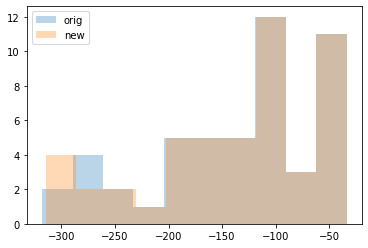

base_1615827722


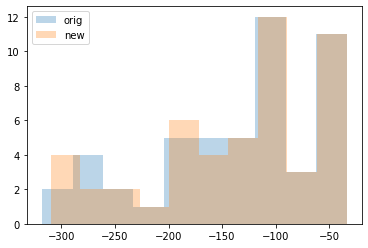

base_1615828169


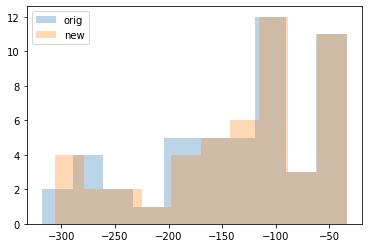

model_1615825376


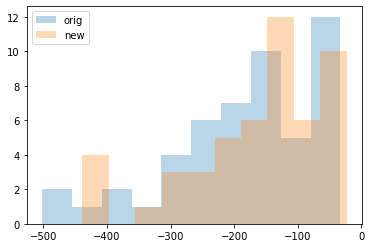

model_1615822571


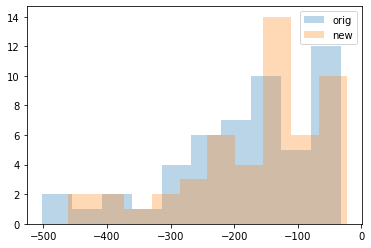

model_1615822038


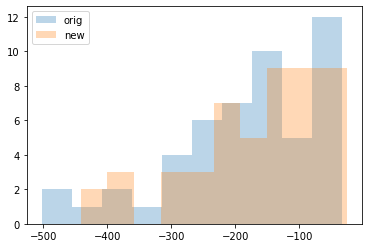

ots_1615825880


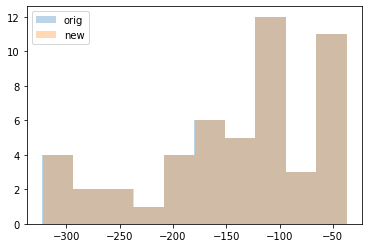

ots_1615826715


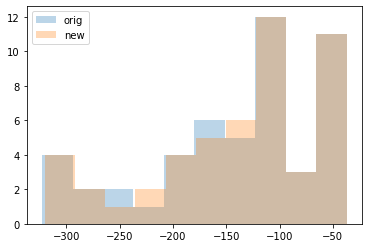

ots_1615826291


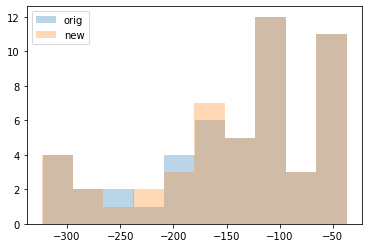

Plotting % Logit Diffs


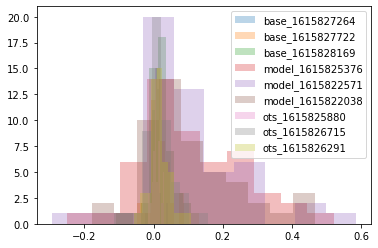

In [49]:
comps.plotter()

# model_epoch0_ts6000.20210314.16.03.1615740151
## cedit=1, cloc=10, 6k steps
Notes: same model, checking to see if evaluating an earlier checkpoint might be better. Tried with a number of checkpoints, generally worse

In [50]:
comps1 = ModelComps(
    model_name="model_epoch0_ts6000.20210314.16.03.1615740151",
    base_name="gpt2_epoch0_ts10000.20210310.18.03.1615401990",
    archive=False
)

comps1.summary()

Model Parameters:


,inner_lr,outer_lr,n_edit_steps,cedit,cloc
0,0.001,0.00001,1.0,1.0,10.0


Success Metrics


,model,edit_steps,mean_new_ppl,mean_orig_ppl,pct_ppl_dd,gross_ppl_dd,new_logits_higher,new_logits_higher05,new_logits_higher10,success_by_probs
7,ots_1615826715,5.0,92.249127,90.703072,1.704523,1.546055,0.72,0.16,0.04,0.86
8,ots_1615826291,3.0,91.357340,90.703072,0.721330,0.654268,0.78,0.08,0.02,0.86
6,ots_1615825880,1.0,90.831759,90.703072,0.141878,0.128688,0.80,0.00,0.00,0.86
3,model_1615835384,5.0,103.998292,85.292526,21.931307,18.705765,0.86,0.70,0.52,0.90
4,model_1615834972,3.0,102.605914,85.292526,20.298834,17.313388,0.80,0.64,0.50,0.92
5,model_1615834590,1.0,85.984239,85.292526,0.810988,0.691712,0.88,0.64,0.36,0.94
2,base_1615828169,5.0,50.140138,49.353867,1.593129,0.786271,0.82,0.16,0.04,0.88
1,base_1615827722,3.0,49.605848,49.353867,0.510561,0.251981,0.84,0.08,0.00,0.88
0,base_1615827264,1.0,49.365100,49.353867,0.022761,0.011233,0.82,0.00,0.00,0.92


# model_epoch0_ts18000.20210315.00.03.1615768579
## cedit=1, cloc=10, 18k steps
Notes: Tried running model for many more steps to see if additional performance could be gained

In [51]:
comps2 = ModelComps(
    model_name="model_epoch0_ts18000.20210315.00.03.1615768579",
    base_name="gpt2_epoch0_ts10000.20210310.18.03.1615401990",
    archive=False
)

comps2.summary()

Model Parameters:


,inner_lr,outer_lr,n_edit_steps,cedit,cloc
0,0.001,0.00001,1.0,1.0,10.0


Success Metrics


,model,edit_steps,mean_new_ppl,mean_orig_ppl,pct_ppl_dd,gross_ppl_dd,new_logits_higher,new_logits_higher05,new_logits_higher10,success_by_probs
7,ots_1615826715,5.0,92.249127,90.703072,1.704523,1.546055,0.72,0.16,0.04,0.86
8,ots_1615826291,3.0,91.357340,90.703072,0.721330,0.654268,0.78,0.08,0.02,0.86
6,ots_1615825880,1.0,90.831759,90.703072,0.141878,0.128688,0.80,0.00,0.00,0.86
5,model_1615829457,5.0,87.205313,75.677681,15.232539,11.527632,0.68,0.60,0.46,0.92
3,model_1615829048,3.0,83.930170,75.677681,10.904785,8.252489,0.64,0.50,0.36,0.94
4,model_1615828661,1.0,76.592660,75.677681,1.209047,0.914979,0.66,0.52,0.40,0.94
2,base_1615828169,5.0,50.140138,49.353867,1.593129,0.786271,0.82,0.16,0.04,0.88
1,base_1615827722,3.0,49.605848,49.353867,0.510561,0.251981,0.84,0.08,0.00,0.88
0,base_1615827264,1.0,49.365100,49.353867,0.022761,0.011233,0.82,0.00,0.00,0.92


Plotting Logits
base_1615827264


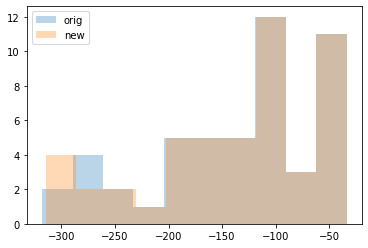

base_1615827722


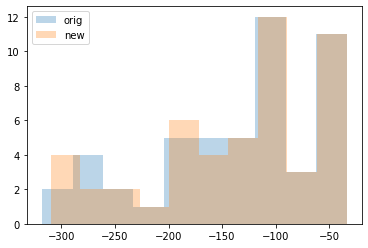

base_1615828169


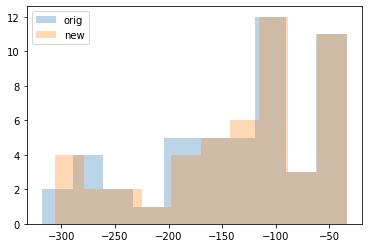

model_1615829048


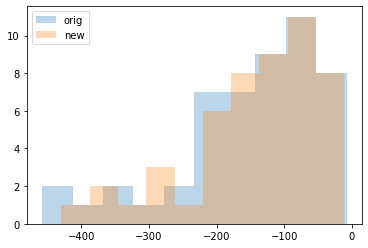

model_1615828661


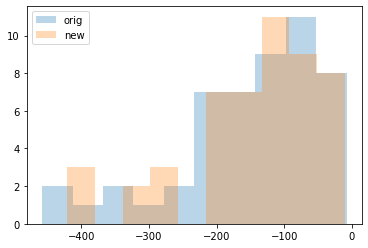

model_1615829457


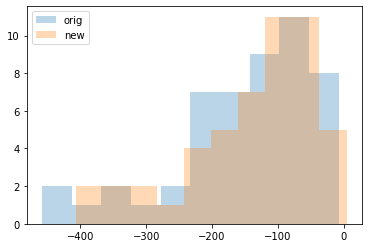

ots_1615825880


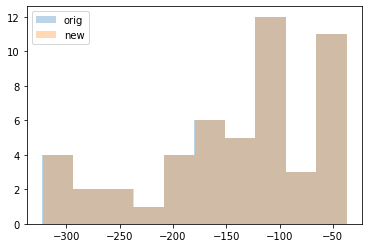

ots_1615826715


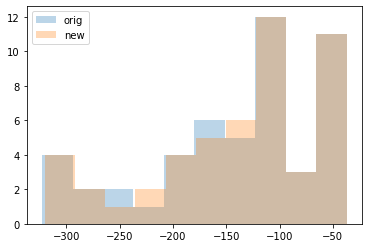

ots_1615826291


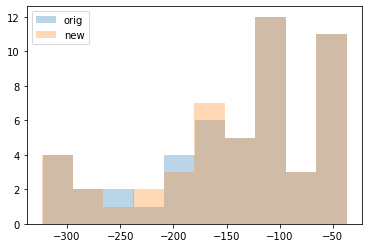

Plotting % Logit Diffs


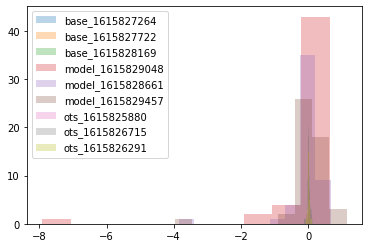

In [52]:
comps2.plotter()

# model_epoch0_ts10000.20210314.22.03.1615760445
## cedit=1, cloc=15, 10k steps


In [53]:
comps3 = ModelComps(
    model_name="model_epoch0_ts10000.20210314.22.03.1615760445",
    base_name="gpt2_epoch0_ts10000.20210310.18.03.1615401990",
    archive=False
)

comps3.summary()

Model Parameters:


,inner_lr,outer_lr,n_edit_steps,cedit,cloc
0,0.001,0.00001,1.0,1.0,15.0


Success Metrics


,model,edit_steps,mean_new_ppl,mean_orig_ppl,pct_ppl_dd,gross_ppl_dd,new_logits_higher,new_logits_higher05,new_logits_higher10,success_by_probs
7,ots_1615826715,5.0,92.249127,90.703072,1.704523,1.546055,0.72,0.16,0.04,0.86
8,ots_1615826291,3.0,91.357340,90.703072,0.721330,0.654268,0.78,0.08,0.02,0.86
6,ots_1615825880,1.0,90.831759,90.703072,0.141878,0.128688,0.80,0.00,0.00,0.86
4,model_1615830698,5.0,92.998480,80.843575,15.035091,12.154905,0.86,0.60,0.48,0.92
3,model_1615830286,3.0,86.252994,80.843575,6.691217,5.409419,0.76,0.62,0.50,0.92
5,model_1615829897,1.0,80.696640,80.843575,-0.181751,-0.146934,0.74,0.54,0.44,0.94
2,base_1615828169,5.0,50.140138,49.353867,1.593129,0.786271,0.82,0.16,0.04,0.88
1,base_1615827722,3.0,49.605848,49.353867,0.510561,0.251981,0.84,0.08,0.00,0.88
0,base_1615827264,1.0,49.365100,49.353867,0.022761,0.011233,0.82,0.00,0.00,0.92


Plotting Logits
base_1615827264


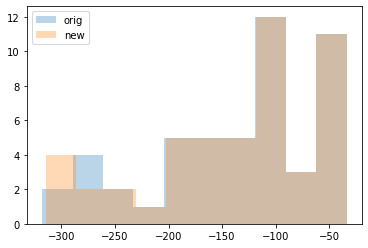

base_1615827722


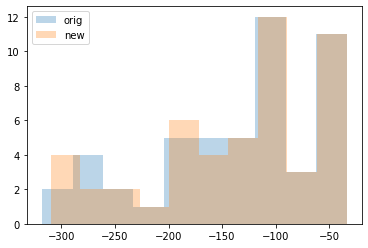

base_1615828169


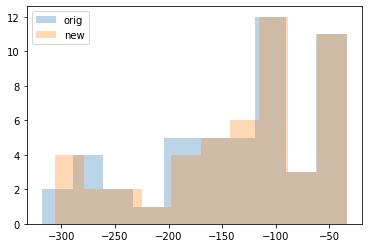

model_1615830286


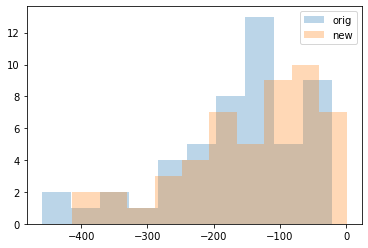

model_1615830698


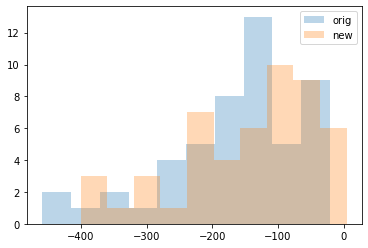

model_1615829897


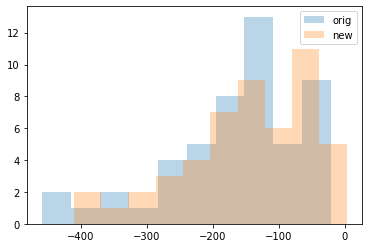

ots_1615825880


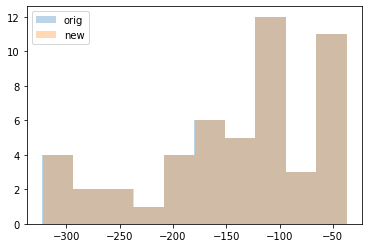

ots_1615826715


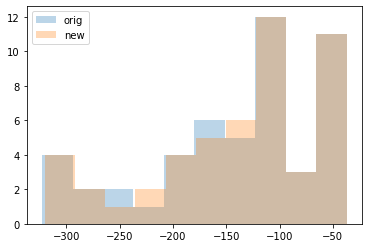

ots_1615826291


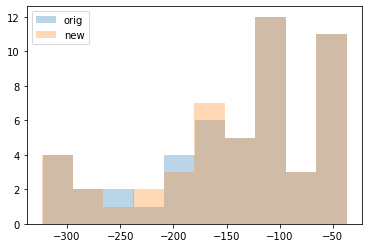

Plotting % Logit Diffs


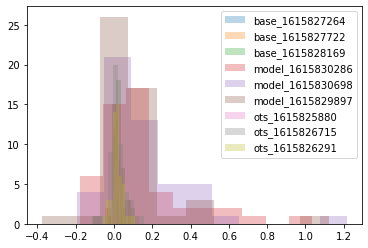

In [54]:
comps3.plotter()

# model_epoch0_ts10000.20210312.21.03.1615586239
## cedit=1, cloc=1, 10k steps
Notes: Model run Friday 3/12, first try with editing loss calculated just on the modified tokens. Has worse statistics

In [55]:
comps = ModelComps(
    model_name="model_epoch0_ts10000.20210312.21.03.1615586239",
    base_name="gpt2_epoch0_ts10000.20210310.18.03.1615401990",
    archive=False
)

comps.summary()

Model Parameters:


,inner_lr,outer_lr,n_edit_steps,cedit,cloc
0,0.001,0.00001,1.0,1.0,1.0


Success Metrics


,model,edit_steps,mean_new_ppl,mean_orig_ppl,pct_ppl_dd,gross_ppl_dd,new_logits_higher,new_logits_higher05,new_logits_higher10,success_by_probs
7,ots_1615826715,5.0,92.249127,90.703072,1.704523,1.546055,0.72,0.16,0.04,0.86
8,ots_1615826291,3.0,91.357340,90.703072,0.721330,0.654268,0.78,0.08,0.02,0.86
6,ots_1615825880,1.0,90.831759,90.703072,0.141878,0.128688,0.80,0.00,0.00,0.86
3,model_1615833209,5.0,184.372973,94.858231,94.366869,89.514742,0.90,0.70,0.58,0.92
5,model_1615832802,3.0,162.421238,94.858231,71.225245,67.563007,0.90,0.70,0.56,0.94
4,model_1615832420,1.0,137.337339,94.858231,44.781679,42.479109,0.86,0.72,0.56,0.92
2,base_1615828169,5.0,50.140138,49.353867,1.593129,0.786271,0.82,0.16,0.04,0.88
1,base_1615827722,3.0,49.605848,49.353867,0.510561,0.251981,0.84,0.08,0.00,0.88
0,base_1615827264,1.0,49.365100,49.353867,0.022761,0.011233,0.82,0.00,0.00,0.92
